# Fashion MNIST using PyTorch

## 1. Importing libraries

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader

# Import torchvision 
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from timeit import default_timer as timer 


# Custom
import mllib.DNN_utils as DNN_utils

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

## 2. Getting dataset

In [2]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="../", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="../",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

### 2.1 Taking a peek at the data

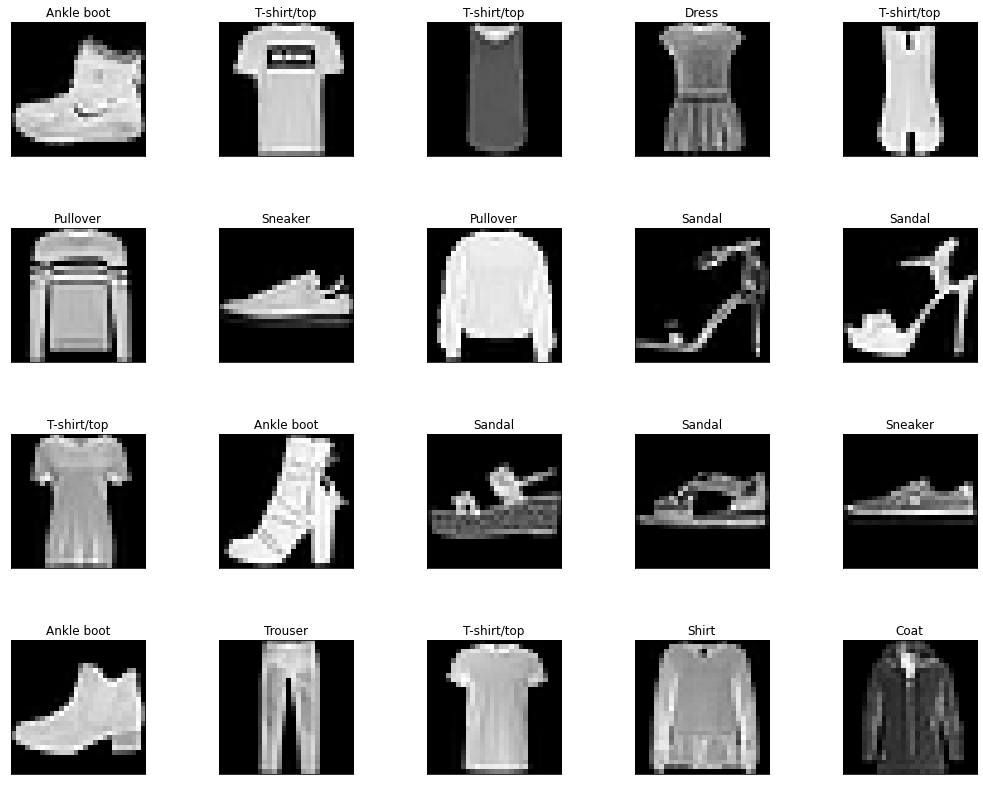

In [3]:
fig, ax = plt.subplots(4,5,figsize=(15,12))
fig.tight_layout(pad=4)
ax = ax.ravel()

for i in range(20):
    ax[i].imshow(train_data[i][0].view(28,28), cmap='gray')
    ax[i].set_title("{}".format(train_data.classes[train_data[i][1]]))
    ax[i].set_xticks([])
    ax[i].set_yticks([])

### 2.2 Loadig the data using DataLoader
- Helps load data into a model for training and inference.

In [4]:
BATCH_SIZE = 32 

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

print("traininig set = {}, testing set = {} of size ={}".format(len(train_dataloader), len(test_dataloader), BATCH_SIZE)) 

traininig set = 1875, testing set = 313 of size =32


## 3. Building a model

### 3.1 Auxillary function

In [77]:
def train_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device="cpu") -> dict:
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    train_loss, train_acc = 0, 0
    model.train()
    for i, (X, y) in enumerate(data_loader):

        X, y = X.to(device), y.to(device)  
        y_pred = model(X)
        
        loss = loss_fn(y_pred, y)
        train_loss += loss
        acc = DNN_utils.accuracy_fn(y_true=y, 
                                     y_pred=y_pred.argmax(dim=1))
        train_acc += acc

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    # Scale loss and acc to find the average loss/acc per batch
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": train_loss.item(),
            "model_acc": train_acc}


def test_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module,
               device: torch.device="cpu") -> dict:
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for i, (X, y) in enumerate(data_loader):
            # Make predictions with the model
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            
            # Accumulate the loss and accuracy values per batch
            loss = loss_fn(y_pred, y)
            test_loss += loss
            acc = DNN_utils.accuracy_fn(y_true=y, 
                                        y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)
            test_acc += acc

        # Scale loss and acc to find the average loss/acc per batch
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": test_loss.item(),
            "model_acc": test_acc}


def get_model_prediction(model: torch.nn.Module, 
                         input_data: torch.Tensor) -> torch.Tensor:
    """ Return the prediction of the model.
    Parameters:
        model <torch.nn.Module>: Model
        input_data <torch.Tensor>: input data to the model
    Returns:
        y_pred <torch.Tensor>: Predicted label
    """
    model.eval()
    with torch.inference_mode():
        y_pred = model(input_data)
        
    return torch.argmax(y_pred)
    

### 3.2 Building a model
- Using nn.Linear building blocks

In [36]:
class FMNIST_model0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
        
    def forward(self,x):
        return self.layer_stack(x)

# With Non-linearity
class FMNIST_model1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
        
    def forward(self,x):
        return self.layer_stack(x)



### 3.3 Training and testing

In [59]:
INPUT_SHAPE = nn.Flatten()(next(iter(train_dataloader))[0][0]).shape[1]
HIDDEN_UNITS = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
FMNIST_model = FMNIST_model1
model = FMNIST_model(input_shape=INPUT_SHAPE, 
    hidden_units=HIDDEN_UNITS, # how many units in the hiden layer
    output_shape=len(train_data.classes) # one for every class
)
model.to(device) 

torch.manual_seed(42)
EPOCHS = 30
train_time_start_on_cpu = timer()

# Loss function and Optimizer 
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)
losses = {'train_loss':[],
          'train_acc':[],
          'test_loss':[],
          'test_acc':[]}
for epoch in tqdm(range(EPOCHS)):
    
    print(f"Epoch: {epoch}\n---------")
    ## TRAINING
    train_results = train_model(model=model, data_loader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, device=device)
    losses['train_loss'].append(train_results['model_loss'])
    losses['train_acc'].append(train_results['model_acc'])
    
    ## Print out what's happening
    print(f"\n Train loss: {train_results['model_loss']:.5f} | Train acc: {train_results['model_acc']:.2f}%\n")
    
    ## TESTING
    test_results = test_model(model=model, data_loader=test_dataloader, loss_fn=loss_fn)
    losses['test_loss'].append(test_results['model_loss'])
    losses['test_acc'].append(test_results['model_acc'])
    
    ## Print out what's happening
    print(f"Test loss: {test_results['model_loss']:.5f} | Test acc: {test_results['model_acc']:.2f}%\n")


train_time_end_on_cpu = timer()
total_train_time_model_0 = DNN_utils.print_train_time(start=train_time_start_on_cpu, 
                                           end=train_time_end_on_cpu,
                                           device=str(next(model.parameters()).device))

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0
---------

 Train loss: 0.88588 | Train acc: 68.26%

Test loss: 0.74357 | Test acc: 73.34%

Epoch: 1
---------

 Train loss: 0.70648 | Train acc: 74.52%

Test loss: 0.75296 | Test acc: 73.30%

Epoch: 2
---------

 Train loss: 0.67966 | Train acc: 75.37%

Test loss: 0.71842 | Test acc: 74.54%

Epoch: 3
---------

 Train loss: 0.66006 | Train acc: 76.01%

Test loss: 0.67088 | Test acc: 75.38%

Epoch: 4
---------

 Train loss: 0.64686 | Train acc: 76.33%

Test loss: 0.66480 | Test acc: 75.72%

Epoch: 5
---------

 Train loss: 0.63494 | Train acc: 76.77%

Test loss: 0.70877 | Test acc: 75.17%

Epoch: 6
---------

 Train loss: 0.62776 | Train acc: 76.94%

Test loss: 0.66941 | Test acc: 75.97%

Epoch: 7
---------

 Train loss: 0.62000 | Train acc: 77.16%

Test loss: 0.68765 | Test acc: 74.92%

Epoch: 8
---------

 Train loss: 0.61501 | Train acc: 77.24%

Test loss: 0.64149 | Test acc: 76.53%

Epoch: 9
---------

 Train loss: 0.60762 | Train acc: 77.55%

Test loss: 0.64247 | Test acc

### 3.4 Visualizing the model performance

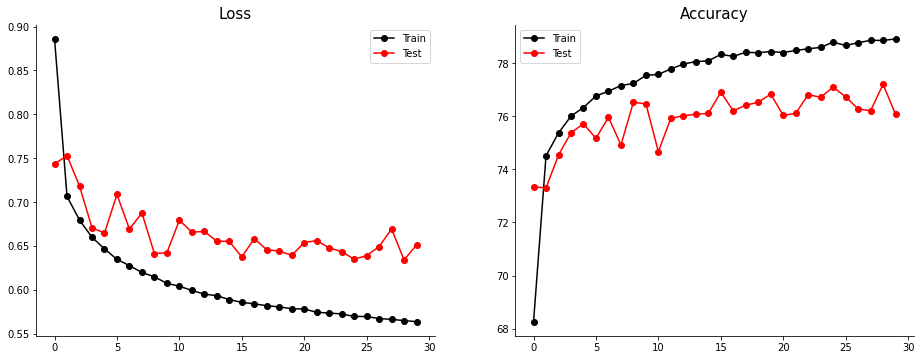

In [60]:
fig, ax = plt.subplots(1,2,figsize=(14,6))
fig.tight_layout(pad=5)

ax[0].plot(losses['train_loss'], '-o', color='k', label='Train')
ax[0].plot(losses['test_loss'], '-o', color='r', label='Test')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].set_title('Loss', fontsize=15)
ax[0].legend()


ax[1].plot(losses['train_acc'], '-o', color='k', label='Train')
ax[1].plot(losses['test_acc'], '-o', color='r', label='Test')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_title('Accuracy', fontsize=15)
ax[1].legend()

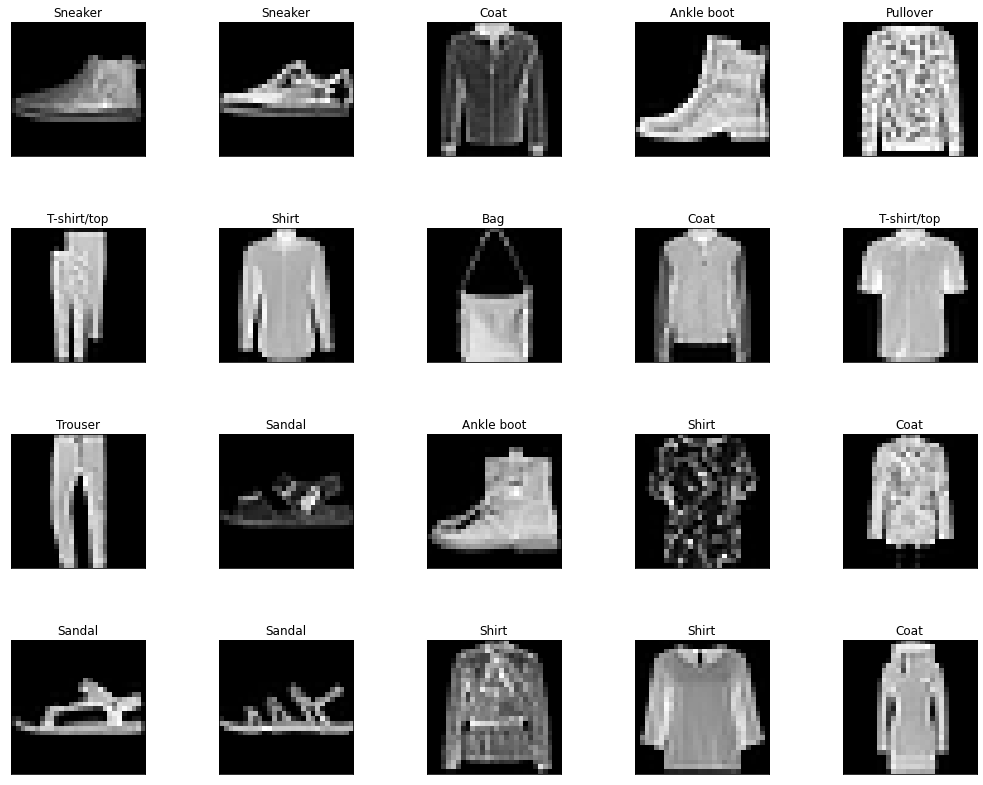

In [88]:
# Plotting the prediction
fig, ax = plt.subplots(4,5,figsize=(15,12))
fig.tight_layout(pad=4)
ax = ax.ravel()

input_data = next(iter(train_dataloader))[0]
for i in range(20):
    pred_label = get_model_prediction(model, input_data[i])
    ax[i].imshow(torch.squeeze(input_data[i]), cmap='gray')
    ax[i].set_title("{}".format(train_data.classes[pred_label]))
    ax[i].set_xticks([])
    ax[i].set_yticks([])

## 4 Building a CNN

### 4.1 Model definition 